In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
from scipy.optimize import curve_fit, leastsq

%matplotlib inline

### Fetching the data from the files

In [64]:
def create_df(filename):
    df= pd.read_json(filename)
    return df

def filter_data(df):    
    mean = df['price'].mean()
    std = df['price'].std()
    lower_range = mean - 2*std
    upper_range = mean + 2*std
    mask = (df['price'] >= lower_range) & (df['price'] <= upper_range)
    print(len(df['price']))
    df = df.loc[mask]
    print(len(df['price']))

    df['departure'] = pd.to_datetime(df['departure'].str[:10])

    df.index = df['departure']
    return df
    
def sort_by_date(df):
    df2 = pd.DataFrame(index=df.index.unique(), columns=['price'])

    for i in df.index.unique():
        df2.loc[i] = pd.Series(df.loc[i, 'price']).quantile(q=0.15)
    return df2



### Loading data to then comapare it to data from other files

In [150]:
BHX_to_IAS = create_df('BHX_to_IAS.json')
BHX_to_IAS = filter_data(BHX_to_IAS)
BHX_to_IAS2 = sort_by_date(BHX_to_IAS)

LTN_to_IAS = create_df('LTN_to_IAS.json')
LTN_to_IAS = filter_data(LTN_to_IAS)
LTN_to_IAS2 = sort_by_date(LTN_to_IAS)

MAN_to_IAS = create_df('MAN_to_IAS.json')
MAN_to_IAS = filter_data(MAN_to_IAS)
MAN_to_IAS2 = sort_by_date(MAN_to_IAS)
df_dict={'BHX_to_IAS':BHX_to_IAS2,
         'MAN_to_IAS':MAN_to_IAS2,
         'LTN_to_IAS':LTN_to_IAS2
         }

14527
14113


C:\Users\micha\AppData\Local\Temp\ipykernel_12104\3184079549.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['departure'] = pd.to_datetime(df['departure'].str[:10])


4007
3877


C:\Users\micha\AppData\Local\Temp\ipykernel_12104\3184079549.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['departure'] = pd.to_datetime(df['departure'].str[:10])


12508
12043


C:\Users\micha\AppData\Local\Temp\ipykernel_12104\3184079549.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['departure'] = pd.to_datetime(df['departure'].str[:10])


In [3]:
def hist(df, bin):

    x = df['price']
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.legend(['The price density of flights from BHX to IAS'])
    ax.set_xlabel('price')
    ax.set_ylabel('density')
    ax.set_xticks(np.arange(0, np.max(x)+1, 100))
    ax.hist(x, bins=bin)

### Second attempt at trying to find a line of best fit for my data

In [148]:
def line_best_fit(df,ax, filename, colour):
    y = df['price']
    x = df.index

    x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')

    # Finding the amplitude of the sin waves
    amp = abs(np.fft.fft(y))
    # Finding the frequency of the sin waves
    freq = np.fft.fftfreq(len(x_line), (x_line[1]-x_line[0]))
    guess_amp = np.std(y) * 2**0.5
    guess_freq = abs(freq[np.argmax(amp[1:])+1])
    print(guess_freq)
    phase = 0
    guess_offset = np.mean(y)
    guess = [guess_amp, 2*np.pi*guess_freq, phase,  guess_offset]


    def sinfunc(x, a, w, p, c):
        return a * np.sin(x*w+p)  + c

    def combine_funcs(x_line, y, a, w, p, c):
    #x_line, y, a, w, p, c=x_line, y, amp, freq*np.pi*2, 0, guess_offset
        total = np.zeros(shape=len(x_line))
        est_amps = np.empty(len(a))
        est_freq = np.empty(len(a))
        est_phase = np.empty(len(a))
        est_offset = np.empty(len(a))
        for i in range(len(a)):
            popt, pcov= curve_fit(sinfunc, x_line, y,  p0 = [a[i], w[i], p, c])
            est_amps[i] = popt[0]
            est_freq[i] = popt[1]
            est_phase[i] = popt[2]
            est_offset[i] = popt[3]

        ind = np.argpartition(est_amps, -5)[-5:]
        print(ind)
        print(est_amps)
        for i in ind:
            print(est_amps[i])
            total += sinfunc(x_line, est_amps[i], est_freq[i], est_phase[i], est_offset[i]) - est_offset[i]


        return total + c

    #popt, pcov = curve_fit(sinfunc, x_line, y, p0=guess)
    y_line2= combine_funcs(x_line,y, amp, 2*np.pi*freq, phase,  guess_offset)
    #ax.scatter(x, y, color = 'red', marker='.', color=colour)
    #ax.plot(x, y_line2, color=colour, label=filename)

    return y_line2, x, y


### Trying to do curve_fit on the fourier model that I have

[  0.6 280. ]


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


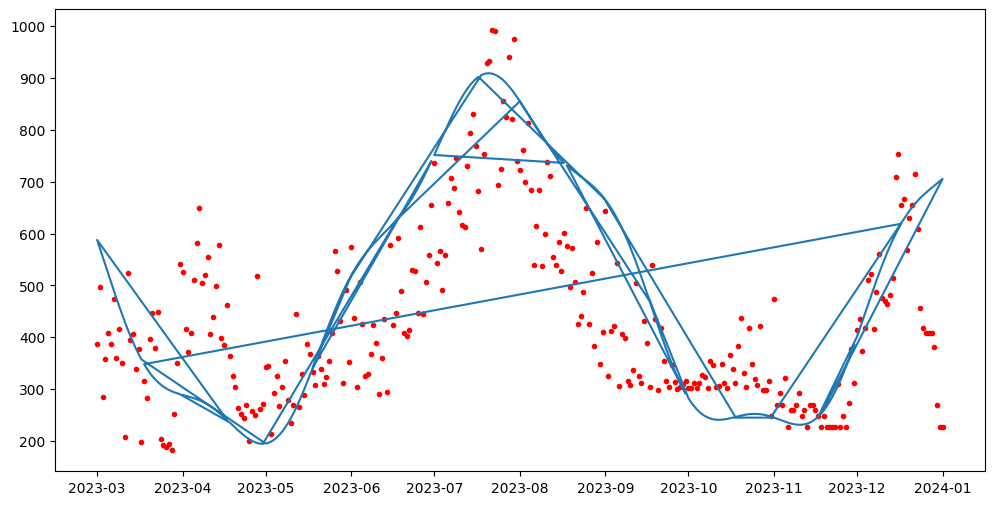

In [186]:
#y_line2, x, y = line_best_fit(df_dict['LTN_to_IAS'], 0, 'LTN_to_IAS', 'red')

fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(x, y, color = 'red', marker='.')
def second_model(x, a, b):
    return x*a + b
x_line = (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
popt, pcov = curve_fit(second_model, y_line2, x, p0=[0.6, 280])
y_line3 = second_model(y_line2, *popt)
print(popt)
ax.plot(x, y_line3)


### Third attempt at trying to find a line of best fit for my data

In [ ]:
y = df2['price']
x = df2.index
print(type(y))

def using_legendre(x, y):
    x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
    y = y.astype(int)

    V = np.polynomial.legendre.legvander(x_line, 20)

    coeffs = np.linalg.lstsq(V, y, rcond=None)[0]
    g = np.polynomial.legendre.legval(x_line, coeffs)
    print(g)
    return g
y_line3 = using_legendre(x, y)
fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(x, y, color = 'red', marker='.')
ax.plot(x, y_line3)

### Fourth attempt at trying to find a line of best fit, using lmfit. This is very similar to just curve_fit, but a lot harder to use

['a', 'b', 'c', 'd', 'e']


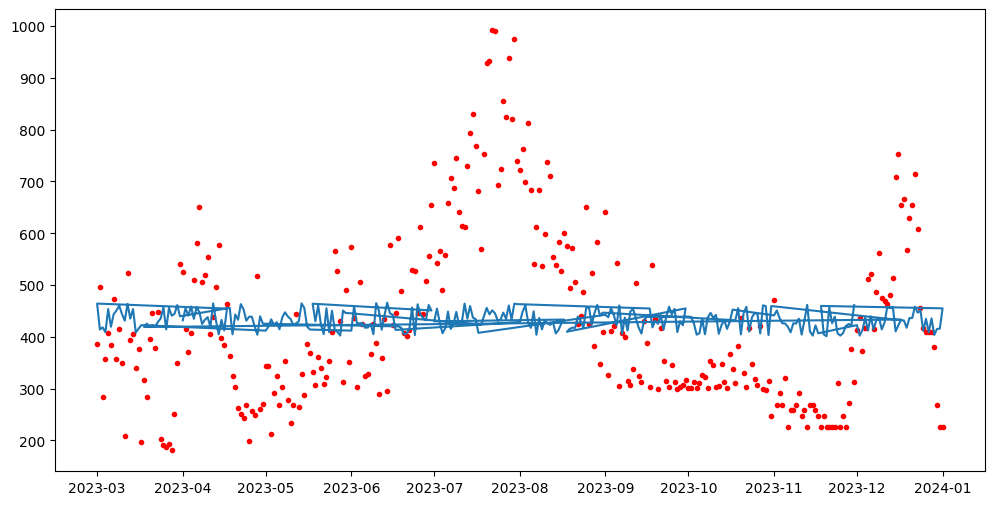

In [88]:
from lmfit import Model

x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
amp = abs(np.fft.fft(y))
freq = np.fft.fftfreq(len(x_line), (x_line[1]-x_line[0]))
guess_freq = abs(freq[np.argmax(amp[1:])+1])
guess_amp = np.std(y) * 2**0.5
guess_offset = np.mean(y)

def function_model(x, a, b, c, d, e):
    return a*x**4+ b*x**3 + c*x**2 + d*x+ e


print(gmodel.param_names)
y_line = gmodel.fit(y,a=3.626958976874177e-26, b=-2.4520898007792085e-16,c=6.216654717368882e-07, d=-700.4707189970496, e= 295971487668.4085, x=x_line)
fig, ax = plt.subplots(figsize = (12, 6))
ax.scatter(x, y, color = 'red', marker='.')
print(y_line)
ax.plot(x, y_line.best_fit)


### Fifth attempt at getting a line of best fit by just modelling a polynomial

3.626958976874177e-26
-2.4520898007792085e-16
6.216654717368882e-07
-700.4707189970496
295971487668.4085


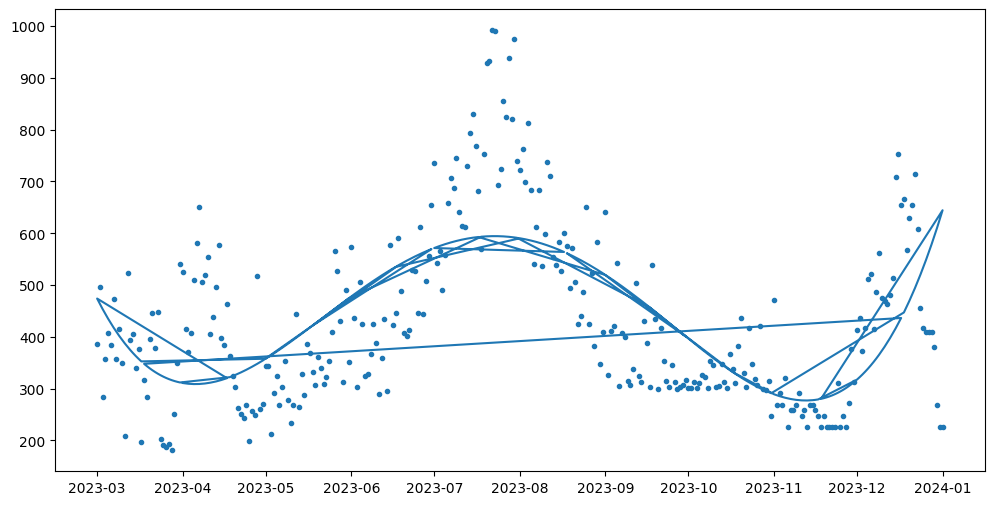

In [89]:
y = LTN_to_IAS2['price']
x = LTN_to_IAS2.index
x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
y = y.astype(int)


def poly_model(x, *param):
    total = np.empty(len(x))
    for i in range(len(param), 1, -1):
        total += param[len(param)-i] * x**i
        print(total)

p= np.polyfit(x_line, y, 4)
y_line = np.polyval(p, x_line)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, y_line)
ax.scatter(x, y, marker='.')



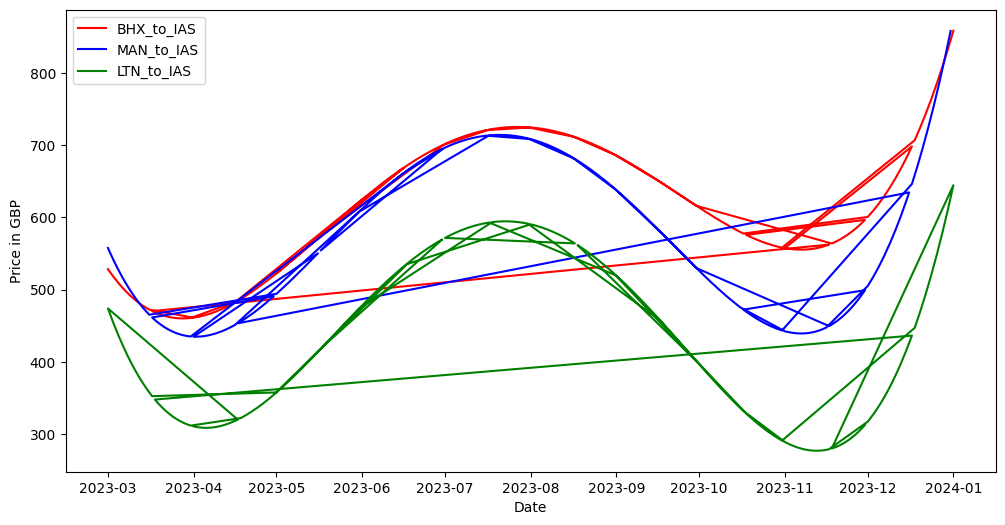

In [96]:
def plot(df,filename,  ax, colour):
    x = df.index
    y = df['price']
    x_line= (x - pd.Timestamp("01/01/1970")) // pd.Timedelta('1s')
    y = y.astype(int)
    
    p= np.polyfit(x_line, y, 4)
    y_line = np.polyval(p, x_line)
    ax.plot(x, y_line, label=filename, color=colour)


    ax.set_ylabel('Price in GBP')
    #ax.set_yticks(np.arange(0, np.max(y)+1, 100))
    ax.set_xlabel('Date')
    #ax.scatter(x, y, marker ='.', color=colour, label=filename)
    ax.legend()

fig, ax = plt.subplots(figsize =(12, 6))
plot(BHX_to_IAS2,'BHX_to_IAS', ax, colour='red')
plot(MAN_to_IAS2,'MAN_to_IAS', ax, colour='blue')
plot(LTN_to_IAS2,'LTN_to_IAS', ax, colour='green')

